In [1]:
from simpletransformers.ner import NERModel, NERArgs

In [2]:
special_labels = {',': 'I-COMMA',
                  '.': 'I-DOT',
                  '?': 'I-QMARK',
                  '!': 'I-EMARK',
                  ':': 'I-COLON',
                  ';': 'I-SEMICOLON'}
normal_label = 'O'
labels_set = list(special_labels.values()) + [normal_label]

In [3]:
model_args = NERArgs()
model_args.overwrite_output_dir = True
model_args.save_steps = -1
model = NERModel('bert',
                 './models/6/checkpoint-13483-epoch-1/',
                 labels = labels_set,
                 args=model_args,
                 use_cuda=True)

In [4]:
import pandas as pd

testdf = pd.read_csv('./wikitext/test.csv').dropna()

In [5]:
result, model_outputs, predictions = model.eval_model(testdf)

  0%|          | 0/6 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/328 [00:00<?, ?it/s]

In [6]:
groups = [df for _, df in testdf.groupby('sentence_id')]

In [7]:
print(len(predictions) == len(groups))

True


In [8]:
trues = []
for i, sentence in enumerate(predictions):
  trues.append(groups[i]['labels'].to_list()[:len(sentence)])

In [9]:
print(len(trues), len(predictions))

2618 2618


In [10]:
import itertools
ps = list(itertools.chain.from_iterable(predictions))
ts = list(itertools.chain.from_iterable(trues))

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true=ts,y_pred=ps, labels=labels_set)
cm

array([[  6749,    192,      0,      0,      9,      8,   1126],
       [   245,   5821,      1,      0,     12,      9,    283],
       [     0,      0,      6,      0,      0,      0,      0],
       [     3,      2,      0,      6,      0,      0,      5],
       [    30,     42,      0,      0,    142,      2,     26],
       [    55,    231,      0,      0,      2,     39,     17],
       [  1274,    285,      0,      4,     11,      7, 157018]])

In [12]:
import numpy as np
summ = np.sum(cm, axis=1)
summ = np.expand_dims(summ, axis=1)

In [13]:
nor_cm = (cm/summ)
nor_cm

array([[8.34858981e-01, 2.37506185e-02, 0.00000000e+00, 0.00000000e+00,
        1.11331024e-03, 9.89609104e-04, 1.39287481e-01],
       [3.84555015e-02, 9.13671323e-01, 1.56961231e-04, 0.00000000e+00,
        1.88353477e-03, 1.41265108e-03, 4.44200283e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.87500000e-01, 1.25000000e-01, 0.00000000e+00, 3.75000000e-01,
        0.00000000e+00, 0.00000000e+00, 3.12500000e-01],
       [1.23966942e-01, 1.73553719e-01, 0.00000000e+00, 0.00000000e+00,
        5.86776860e-01, 8.26446281e-03, 1.07438017e-01],
       [1.59883721e-01, 6.71511628e-01, 0.00000000e+00, 0.00000000e+00,
        5.81395349e-03, 1.13372093e-01, 4.94186047e-02],
       [8.03283753e-03, 1.79698485e-03, 0.00000000e+00, 2.52208400e-05,
        6.93573099e-05, 4.41364700e-05, 9.90031463e-01]])

In [14]:
nor_cm.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1.])

In [15]:
from sklearn import metrics 
print(metrics.classification_report(ts, ps))

              precision    recall  f1-score   support

     I-COLON       0.81      0.59      0.68       242
     I-COMMA       0.81      0.83      0.82      8084
       I-DOT       0.89      0.91      0.90      6371
     I-EMARK       0.60      0.38      0.46        16
     I-QMARK       0.86      1.00      0.92         6
 I-SEMICOLON       0.60      0.11      0.19       344
           O       0.99      0.99      0.99    158599

    accuracy                           0.98    173662
   macro avg       0.79      0.69      0.71    173662
weighted avg       0.98      0.98      0.98    173662



Text(114.0, 0.5, 'True Label')

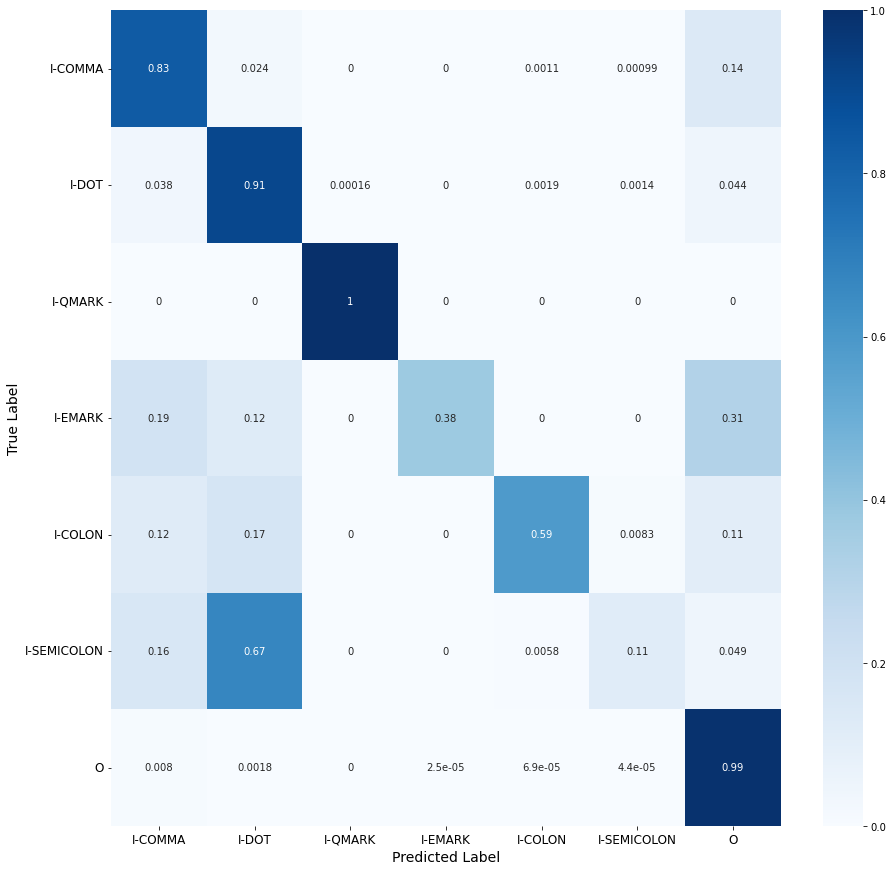

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plot_labels = labels_set
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(nor_cm,
            ax=ax, 
            annot=True,
            cmap='Blues',
            xticklabels=plot_labels,
            yticklabels=plot_labels)
plt.yticks(rotation=0,size=12)
plt.xticks(size=12)
ax.set_xlabel('Predicted Label',size=14)
ax.set_ylabel('True Label',size=14)